# Spatial Graph Neural Network (Spatial GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously generated using Openpose in the JAAD dataset.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [ ]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

# Dataset

## Training dataset

In [2]:
train_dataset = SkeletonsDataset('Data/train_annotations_with_skeletons.csv', normalization='minmax', target='cross')

print('train_dataset len:', len(train_dataset))
print('Shape of each skeletons data (x):', train_dataset.data[0].x.shape)

train_dataset.loadedData

train_dataset len: 34180
Shape of each skeletons data (x): torch.Size([25, 3])


,Unnamed: 0,video,id,frame,occluded,outside,x2,y2,x1,y1,...,pose_front,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected
0,5564,video_0041,0_41_197b,0,0,0,1372.0,740.0,1345.0,651.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.23, 668.429, 0.207086], [1354.37, 668.6...",True
1,5565,video_0041,0_41_197b,1,0,0,1372.0,740.0,1343.0,651.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.24, 668.672, 0.135277], [1354.33, 671.4...",True
2,5566,video_0041,0_41_197b,2,0,0,1371.0,741.0,1341.0,652.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1351.7, 668.601, 0.128466], [1354.19, 671.40...",True
3,5567,video_0041,0_41_197b,3,0,0,1371.0,741.0,1339.0,652.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.15, 668.701, 0.10925], [1354.14, 671.54...",True
4,5568,video_0041,0_41_197b,4,0,0,1371.0,742.0,1337.0,653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1354.12, 668.759, 0.104457], [1351.68, 671.6...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39403,44967,video_0278,0_278_2189b,115,0,0,1135.0,868.0,1029.0,642.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True
39404,44968,video_0278,0_278_2189b,116,0,0,1151.0,874.0,1044.0,643.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True
39405,44969,video_0278,0_278_2189b,117,0,0,1167.0,880.0,1058.0,643.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True
39406,44970,video_0278,0_278_2189b,118,0,0,1183.0,886.0,1073.0,644.0,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True


Important columns:

In [3]:
train_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','cross','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,cross,crossing
0,video_0041,0,-1,"[[1354.23, 668.429, 0.207086], [1354.37, 668.6...",True,crossing,1
1,video_0041,1,-1,"[[1354.24, 668.672, 0.135277], [1354.33, 671.4...",True,crossing,1
2,video_0041,2,-1,"[[1351.7, 668.601, 0.128466], [1354.19, 671.40...",True,crossing,1
3,video_0041,3,-1,"[[1354.15, 668.701, 0.10925], [1354.14, 671.54...",True,crossing,1
4,video_0041,4,-1,"[[1354.12, 668.759, 0.104457], [1351.68, 671.6...",True,crossing,1
...,...,...,...,...,...,...,...
39403,video_0278,115,-1,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True,crossing,1
39404,video_0278,116,-1,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True,crossing,1
39405,video_0278,117,-1,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True,crossing,1
39406,video_0278,118,-1,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True,crossing,1


Number of elements per class:

Training dataset total rows: 34180
Training dataset crossing class samples: 19182
Training dataset not-crossing class samples: 14998


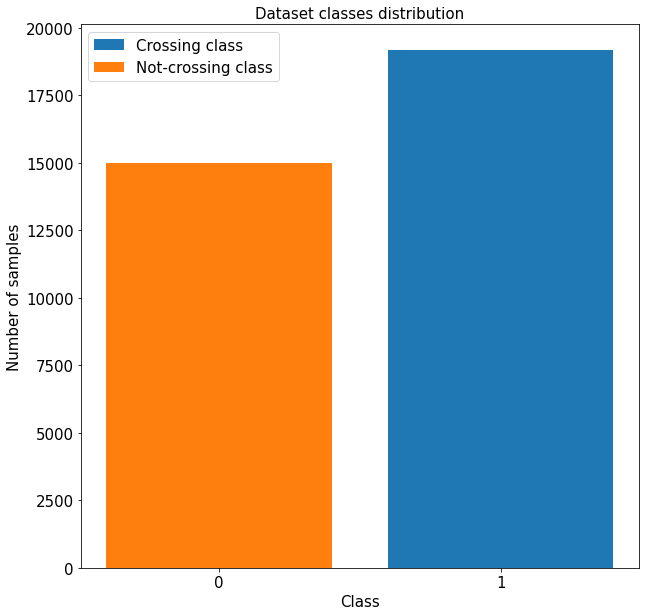

In [4]:
totalRows = len(train_dataset.loadedData)
crossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']=='not-crossing'])

print('Training dataset total rows:', totalRows)
print('Training dataset crossing class samples:', crossingRows)
print('Training dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

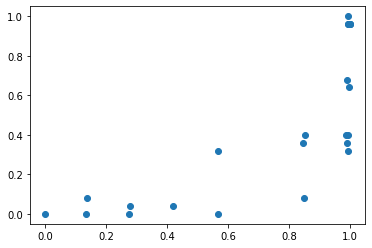

In [5]:
skeleton = train_dataset.data[10].x[:, 0:2].tolist()

skeleton2 = []

for sk in skeleton:
    if(sk!=[0, 0]):
        skeleton2.append(sk)
        
skeleton2 = np.asarray(skeleton2)

plt.figure()
plt.scatter(skeleton2[:, 0], skeleton2[:, 1])
plt.show()

## Validation dataset

In [6]:
val_dataset = SkeletonsDataset('Data/val_annotations_with_skeletons.csv', normalization='minmax', target='cross')
                               # norm_precomputed_values = [train_dataset.xmean, train_dataset.xstd]

val_dataset.shuffle()

In [7]:
print('val_dataset len:', len(val_dataset))
print('Shape of each skeletons data (x):', val_dataset.data[0].x.shape)

val_dataset.loadedData

val_dataset len: 4223
Shape of each skeletons data (x): torch.Size([25, 3])


,video,id,frame,occluded,outside,x2,y2,x1,y1,age,...,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected,outputs
0,video_0280,0_280_2201b,0,0,0,641.0,846.0,618.0,772.0,adult,...,0,1,0,0,0,moving_fast,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[627.482, 621.559, 0.257434], [627.388, 645.0...",True,"[[631.0001220703125, 622.58251953125], [629.85..."
65,video_0280,0_280_2201b,65,0,0,640.0,882.0,569.0,763.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.243, 621.402, 0.379725], [600.817, 636.2...",True,"[[617.3148803710938, 615.83544921875], [616.56..."
66,video_0280,0_280_2201b,66,0,0,640.0,883.0,571.0,764.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.273, 618.514, 0.335216], [594.962, 630.3...",True,"[[588.305419921875, 612.5685424804688], [587.1..."
67,video_0280,0_280_2201b,67,0,0,640.0,883.0,572.0,765.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.232, 621.44, 0.422622], [580.398, 647.9,...",True,"[[587.4631958007812, 628.0204467773438], [585...."
68,video_0280,0_280_2201b,68,0,0,640.0,884.0,574.0,766.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.335, 621.406, 0.615219], [577.496, 645.0...",True,"[[577.976318359375, 622.7041625976562], [576.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,video_0312,0_312_2449b,115,0,0,458.0,983.0,278.0,623.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[318.347, 671.511, 0.894349], [362.597, 692.0...",True,"[[372.368408203125, 659.8908081054688], [369.7..."
5268,video_0312,0_312_2449b,116,0,0,441.0,992.0,252.0,622.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[291.928, 671.461, 0.706857], [338.893, 689.2...",True,"[[350.1001892089844, 637.2662963867188], [345...."
5269,video_0312,0_312_2449b,117,0,0,424.0,1000.0,226.0,620.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[262.442, 665.701, 0.726526], [300.784, 689.1...",True,"[[317.420654296875, 643.6817626953125], [312.8..."
5270,video_0312,0_312_2449b,118,0,0,396.0,1015.0,201.0,619.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[224.293, 668.62, 0.874003], [274.165, 689.24...",True,"[[283.4302978515625, 642.0805053710938], [280...."


Important columns:

In [8]:
val_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','cross','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,cross,crossing
0,video_0280,0,33,"[[627.482, 621.559, 0.257434], [627.388, 645.0...",True,not-crossing,1
65,video_0280,65,33,"[[577.243, 621.402, 0.379725], [600.817, 636.2...",True,crossing,1
66,video_0280,66,33,"[[577.273, 618.514, 0.335216], [594.962, 630.3...",True,crossing,1
67,video_0280,67,33,"[[577.232, 621.44, 0.422622], [580.398, 647.9,...",True,crossing,1
68,video_0280,68,33,"[[577.335, 621.406, 0.615219], [577.496, 645.0...",True,crossing,1
...,...,...,...,...,...,...,...
5267,video_0312,115,-1,"[[318.347, 671.511, 0.894349], [362.597, 692.0...",True,crossing,1
5268,video_0312,116,-1,"[[291.928, 671.461, 0.706857], [338.893, 689.2...",True,crossing,1
5269,video_0312,117,-1,"[[262.442, 665.701, 0.726526], [300.784, 689.1...",True,crossing,1
5270,video_0312,118,-1,"[[224.293, 668.62, 0.874003], [274.165, 689.24...",True,crossing,1


Number of elements per class:

Validation dataset total rows: 4223
Validation dataset crossing class samples: 1510
Validation dataset not-crossing class samples: 2713


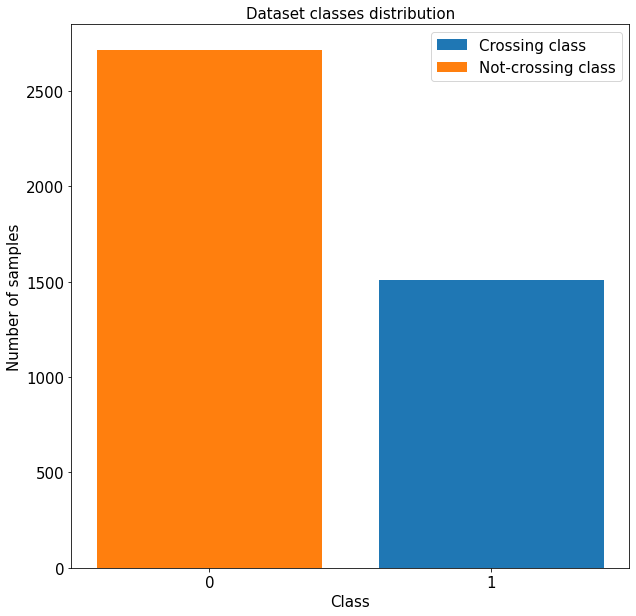

In [9]:
totalRows = len(val_dataset.loadedData)
crossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']=='not-crossing'])

print('Validation dataset total rows:', totalRows)
print('Validation dataset crossing class samples:', crossingRows)
print('Validation dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='best', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

Since the classes of the two datasets are unbalanced, we cannot rely only on accuracy as our metric.

## Showing a skeleton

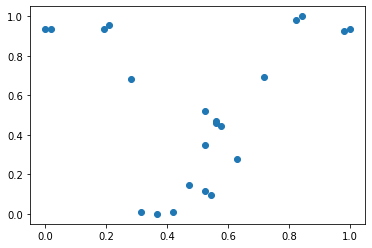

In [10]:
skeleton = val_dataset.data[10].x[:, 0:2].tolist()

skeleton2 = []

for sk in skeleton:
    if(sk!=[0, 0]):
        skeleton2.append(sk)
        
skeleton2 = np.asarray(skeleton2)

plt.figure()
plt.scatter(skeleton2[:, 0], skeleton2[:, 1])
plt.show()

# Training

In [11]:
numberOfClasses = 2

y = train_dataset.loadedData['cross'].to_numpy()
y = np.where(y=='crossing', 1, 0)
bc = np.bincount(y)

class_weights = len(train_dataset.loadedData) / (numberOfClasses * bc)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print('class_weights:', class_weights)

class_weights: tensor([1.1395, 0.8909])


In [12]:
train_dataset.shuffle()

In [13]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 25
Number of features per node: 3


In [14]:
num_epochs = 25
batch_size = 50

device = torch.device('cpu')
model = SpatialGNN(embed_dim, numberOfClasses, numberOfNodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()#weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

loss_values = []

metrics_train = []
metrics_val = []

for epoch in range(num_epochs):

    train_loss = train(model, train_loader, device, optimizer, crit)
    loss_values.append(train_loss)

    train_metrics = evaluate(model, train_loader, device, computed_loss=train_loss)
    val_metrics = evaluate(model, val_loader, device, loss_crit=crit)

    metrics_train.append(train_metrics)
    metrics_val.append(val_metrics)
    
    if num_epochs <= 25:
        
        print_evaluation_train_val(epoch, train_metrics, val_metrics)

Epoch:                           001
Train Loss:                   0.5984  -  Validation Loss:                   0.5991
Train Accuracy:               0.7095  -  Validation Accuracy:               0.6578
Train Balanced accuracy:      0.7049  -  Validation Balanced accuracy:      0.6829
Train Precision:              0.7406  -  Validation Precision:              0.5144
Train Recall:                 0.7423  -  Validation Recall:                 0.7709
Train f1-score:               0.7414  -  Validation f1-score:               0.6170
 


Epoch:                           002
Train Loss:                   0.5619  -  Validation Loss:                   0.6246
Train Accuracy:               0.7145  -  Validation Accuracy:               0.6221
Train Balanced accuracy:      0.7035  -  Validation Balanced accuracy:      0.6630
Train Precision:              0.7241  -  Validation Precision:              0.4830
Train Recall:                 0.7938  -  Validation Recall:                 0.8066
Train f1-

Epoch:                           017
Train Loss:                   0.5281  -  Validation Loss:                   0.6164
Train Accuracy:               0.7387  -  Validation Accuracy:               0.6405
Train Balanced accuracy:      0.7307  -  Validation Balanced accuracy:      0.6756
Train Precision:              0.7525  -  Validation Precision:              0.4983
Train Recall:                 0.7965  -  Validation Recall:                 0.7987
Train f1-score:               0.7738  -  Validation f1-score:               0.6137
 


Epoch:                           018
Train Loss:                   0.5299  -  Validation Loss:                   0.6183
Train Accuracy:               0.7424  -  Validation Accuracy:               0.6443
Train Balanced accuracy:      0.7350  -  Validation Balanced accuracy:      0.6769
Train Precision:              0.7576  -  Validation Precision:              0.5017
Train Recall:                 0.7953  -  Validation Recall:                 0.7914
Train f1-

## Model performance plots

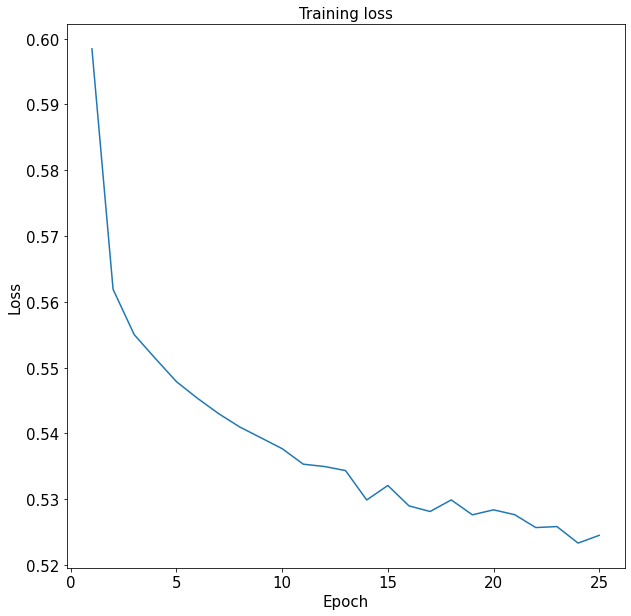

In [15]:
plot_loss(num_epochs, loss_values, figsize=10, textsize=15)

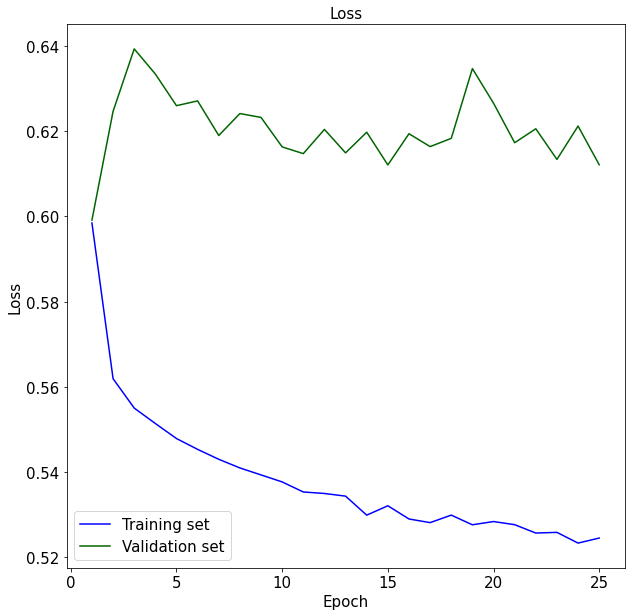

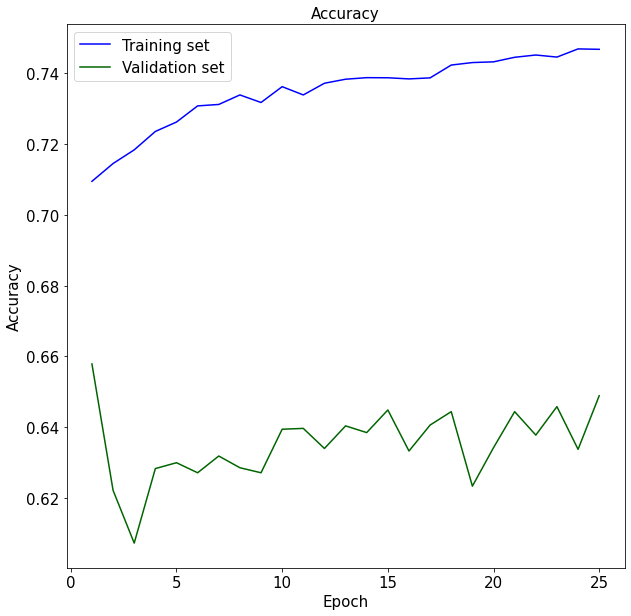

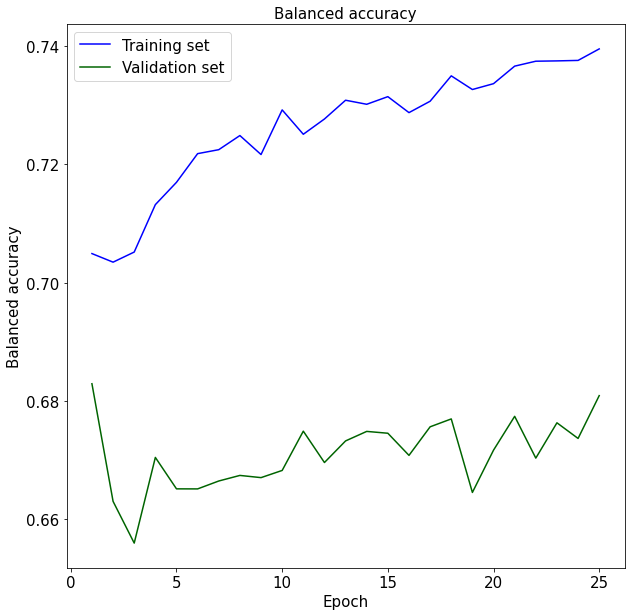

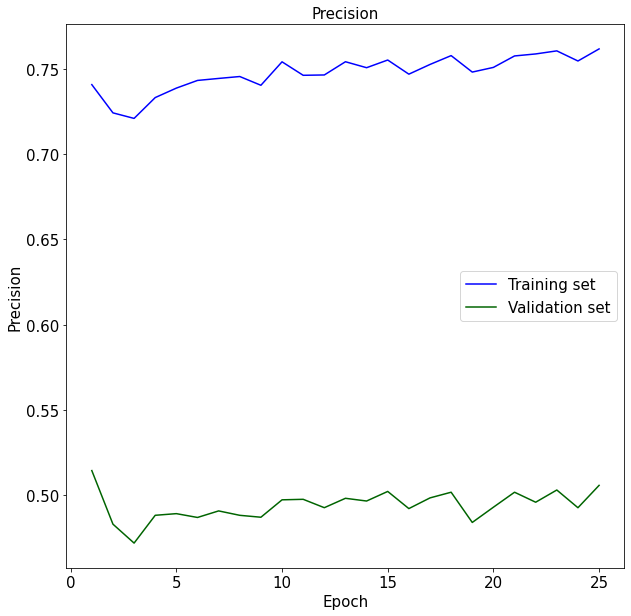

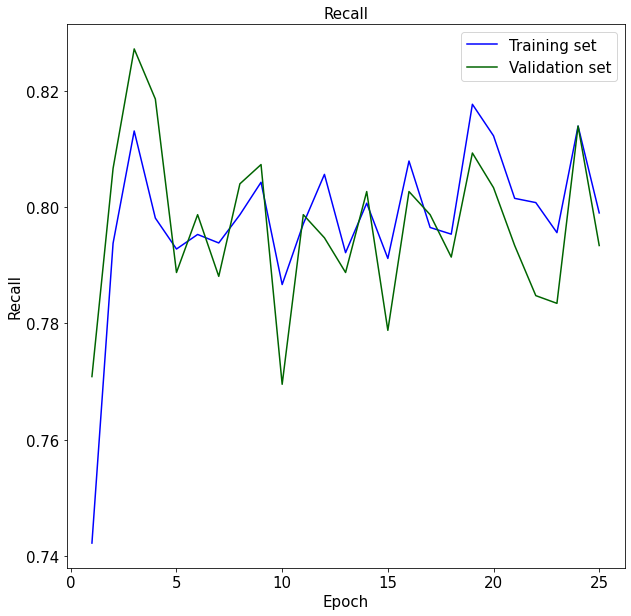

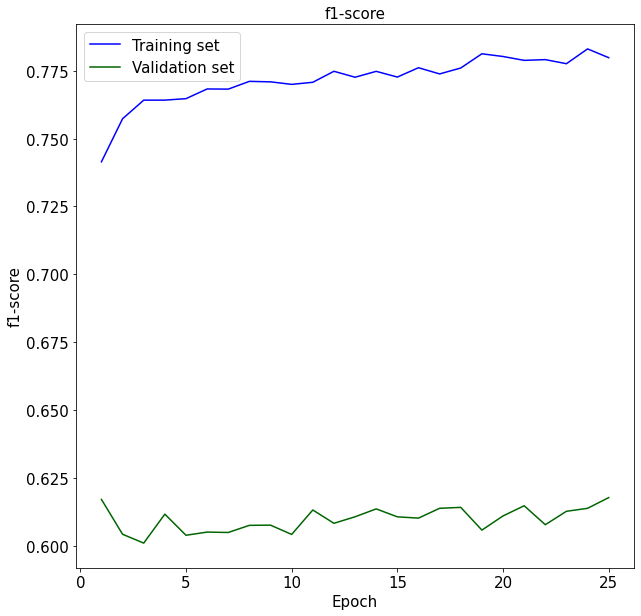

In [16]:
plot_classification_metrics_train_val(num_epochs, metrics_train, metrics_val, figsize=10, textsize=15)

## ROC curves

### Train set

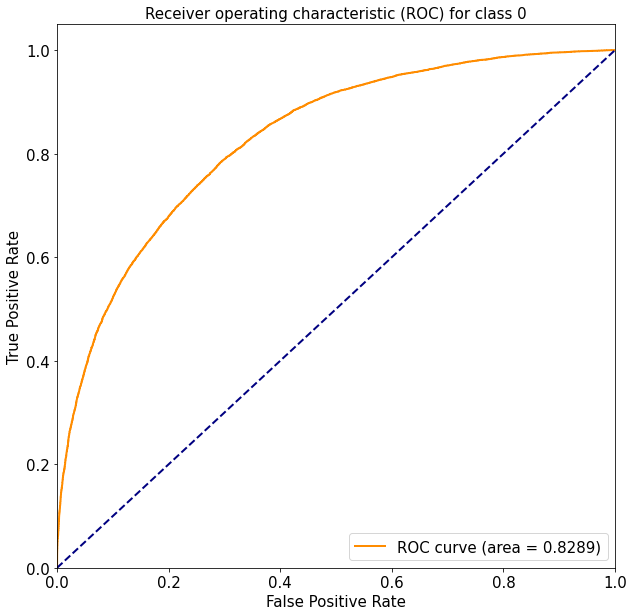

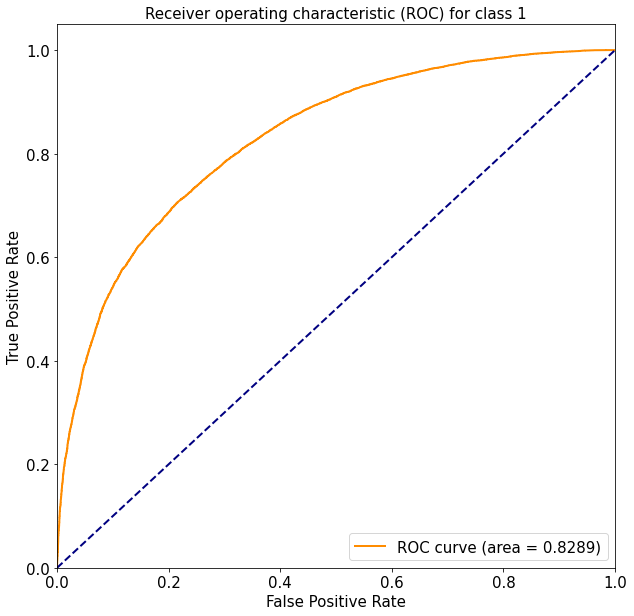

In [17]:
fpr, tpr, roc_auc = ROC(model, train_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

### Validation set

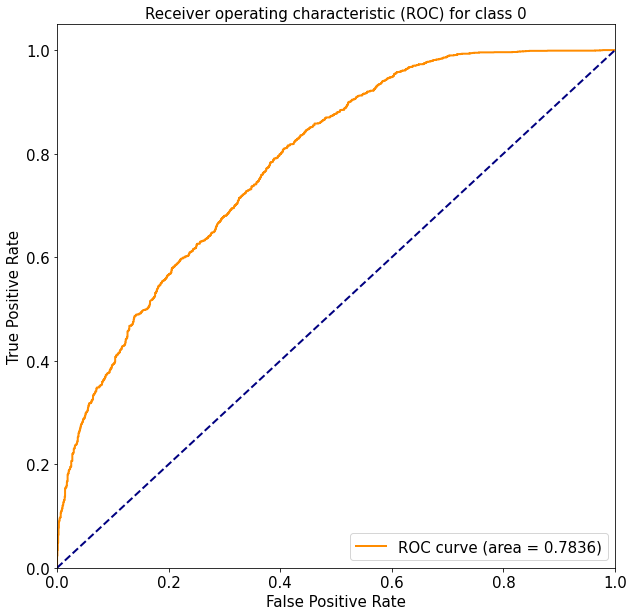

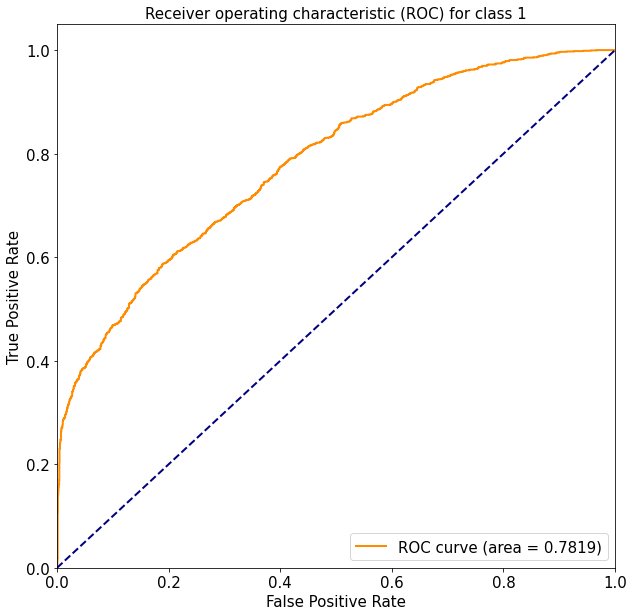

In [18]:
fpr, tpr, roc_auc = ROC(model, val_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

# Testing

## Test dataset

In [19]:
test_dataset = SkeletonsDataset('Data/test_annotations_with_skeletons.csv', normalization='minmax', target='cross')

test_dataset.shuffle()

Number of elements per class:

Test dataset total rows: 4633
Test dataset crossing class samples: 2402
Test dataset not-crossing class samples: 2231


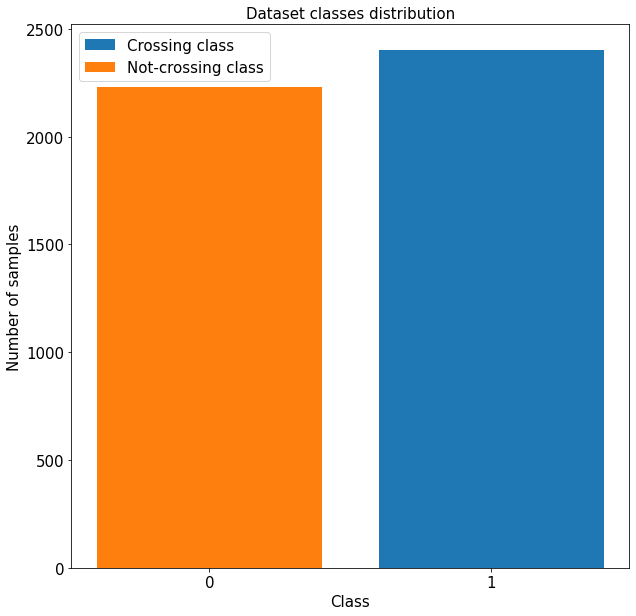

In [20]:
totalRows = len(test_dataset.loadedData)
crossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(test_dataset.loadedData[test_dataset.loadedData['cross']=='not-crossing'])

print('Test dataset total rows:', totalRows)
print('Test dataset crossing class samples:', crossingRows)
print('Test dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='best', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

## Test results

In [21]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_metrics = evaluate(model, test_loader, device)


print_evaluation_test(test_metrics)

Testing subset results:

Accuracy:                 0.6374
Balanced accuracy:        0.6347
Precision:                0.6347
Recall:                   0.7082
f1-score:                 0.6694
 


